# Cluster Experimentation

copy and paste from model.py

In [1]:
import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/isabella_zhu/nanoGPT/env/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/isabella_zhu/nanoGPT/env/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/isabella_zhu/nanoGPT/env/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.

modify gpt code (in model.py) to have a method that returns only outbeddings (before probability distribution)

![Alt text](https://miro.medium.com/v2/resize:fit:696/format:webp/1*0BV8btPZ9k5IiI2l7xZQmA.png)

load the model, from sample.py

In [23]:
import importlib
import model
importlib.reload(model)


<module 'model' from '/Users/isabella_zhu/nanoGPT/model.py'>

In [3]:

import os
import pickle
from contextlib import nullcontext
import torch
import tiktoken
from model import GPT, GPTConfig

In [4]:
# Parameters
out_dir = 'out-tinystories-char'  # Directory where the model is saved
input_string = "Alice and Bob went on a grand adventure together. They started to play a game of chess on a life sized board. "  # Replace with your desired input
max_new_tokens = 500  # Number of tokens to generate
temperature = 0.8  # Controls randomness of predictions
top_k = 200  # Top-k sampling
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'


In [5]:
# Set up PyTorch device and context
torch.manual_seed(1337)
torch.cuda.manual_seed(1337)
device_type = 'cuda' if 'cuda' in device else 'cpu'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

In [24]:
# Load the model
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k, v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)

model.eval()
model.to(device)

number of parameters: 0.81M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(174, 128)
    (wpe): Embedding(64, 128)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-3): 4 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=128, out_features=384, bias=False)
          (c_proj): Linear(in_features=128, out_features=128, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=128, out_features=512, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=512, out_features=128, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=128, out_features=174, bias=False)
)

In [7]:
# Load encoding/decoding
meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
if os.path.exists(meta_path):
    print(f"Loading meta from {meta_path}...")
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    stoi, itos = meta['stoi'], meta['itos']
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
else:
    print("No meta.pkl found, assuming GPT-2 encodings...")
    enc = tiktoken.get_encoding("gpt2")
    encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
    decode = lambda l: enc.decode(l)


Loading meta from data/tinystories_char/meta.pkl...


In [8]:
# Encode the input string
start_ids = encode(input_string)
x = torch.tensor(start_ids, dtype=torch.long, device=device).unsqueeze(0)

In [15]:
# Generate text
with torch.no_grad():
    with ctx:
        token_embeddings = model.transformer.wte(x)
        embedding_shape = token_embeddings.shape

In [11]:
# Display the embeddings and their shape
print("Embeddings shape:", embedding_shape)
print("Embeddings:", token_embeddings)

Embeddings shape: torch.Size([1, 110, 128])
Embeddings: tensor([[[-0.0200, -0.0595,  0.0366,  ...,  0.0117, -0.0178, -0.0139],
         [ 0.0436,  0.0193, -0.0354,  ..., -0.0415, -0.0279,  0.0134],
         [-0.0843,  0.0800, -0.0475,  ..., -0.0615,  0.0677,  0.1072],
         ...,
         [ 0.0396,  0.0171, -0.0589,  ..., -0.0891, -0.0353, -0.1055],
         [ 0.1789, -0.0575,  0.0230,  ...,  0.0841, -0.0392,  0.0873],
         [ 0.1123,  0.0128, -0.0301,  ..., -0.1019,  0.0378,  0.0712]]])


In [25]:
with torch.no_grad():
    with ctx:
        all_embeddings = model.get_embeddings(x)
        for emb in all_embeddings:
            # print(emb)
            print(emb.shape)

torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])


## KMeans Clustering

In [27]:
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Function to find the best K
def find_best_k(data, max_k=10):
    best_k = 2
    best_score = -1
    best_labels = None

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)  # Silhouette Score

        if score > best_score:
            best_k = k
            best_score = score
            best_labels = labels

    return best_k, best_labels, best_score

# Find the best K and get the cluster labels
best_k, best_labels, best_score = find_best_k(outbeddings.squeeze(0).numpy(), max_k=10)

print(f"Best K: {best_k}, Silhouette Score: {best_score}")
print("Cluster Labels:", best_labels)

/Users/isabella_zhu/nanoGPT/env/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Best K: 5, Silhouette Score: 0.18255698680877686
Cluster Labels: [3 0 2 2 0 4 3 0 0 4 1 4 0 4 1 3 2 0 4 3 0 4 3 4 1 1 3 0 0 4 3 0 1 3 2 0 3
 1 3 4 1 0 1 2 1 1 3 0 0 4 1 1 0 0 4 4 1 3 2 1 3 0 4 1]


In [28]:
def cluster_to_word_map(k, ids, labels):
    m = {
        i : [] for i in range(k)
    }

    for i in range(len(labels)):
        m[labels[i]].append(decode([ids[i]]))
    
    return m

In [29]:
cluster_to_word_map(best_k, start_ids, best_labels)

{0: ['l',
  'e',
  'n',
  'd',
  'b',
  't',
  'n',
  'n',
  'd',
  'd',
  't',
  'o',
  'r',
  '.',
  'e',
  'y',
  'd'],
 1: ['B',
  'w',
  'g',
  'r',
  'v',
  'r',
  't',
  'g',
  't',
  'h',
  'T',
  'h',
  't',
  't',
  't'],
 2: ['i', 'c', 'n', 'n', 'e', 'r'],
 3: ['A', 'a', 'e', 'o', 'a', 'a', 'a', 'e', 'u', 'e', 'e', 'a', 'e'],
 4: [' ', ' ', 'o', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 's', ' ']}

/Users/isabella_zhu/nanoGPT/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/isabella_zhu/nanoGPT/env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


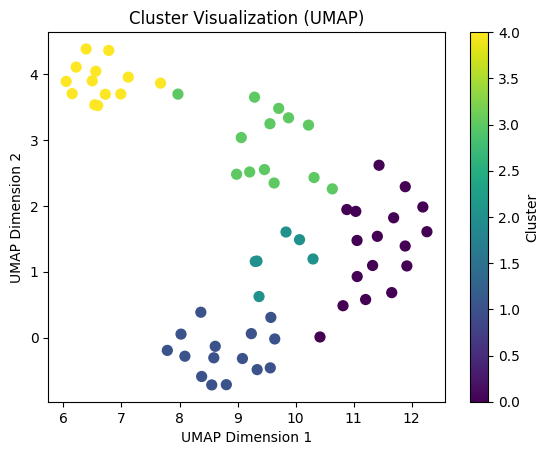

In [31]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Reduce to 2D using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_data = umap_reducer.fit_transform(outbeddings.squeeze(0).numpy())

# Plot the clusters
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=best_labels, cmap='viridis', s=50)
plt.title("Cluster Visualization (UMAP)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Cluster")
plt.show()

In [34]:
import umap.umap_ as umap
import plotly.express as px
import numpy as np

# Assume 'tokens' is a list of token strings corresponding to the embeddings
tokens = [decode([thing]) for thing in start_ids[:64]]

# Reduce to 2D using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_data = umap_reducer.fit_transform(outbeddings.squeeze(0).numpy())

# Create a DataFrame for visualization
import pandas as pd
data = pd.DataFrame(reduced_data, columns=["UMAP Dimension 1", "UMAP Dimension 2"])
data["Token"] = tokens  # Add tokens
data["Cluster"] = best_labels  # Add cluster labels

# Plot with Plotly
fig = px.scatter(
    data,
    x="UMAP Dimension 1",
    y="UMAP Dimension 2",
    color="Cluster",
    text="Token",  # This will show the token on hover
    title="Cluster Visualization with Tokens",
)

# Customize hover
fig.update_traces(marker=dict(size=8), hovertemplate="<b>Token:</b> %{text}<br>")

# Show the interactive plot
fig.show()


/Users/isabella_zhu/nanoGPT/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/isabella_zhu/nanoGPT/env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## Spectral Clustering

/Users/isabella_zhu/nanoGPT/env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/isabella_zhu/nanoGPT/env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/isabella_zhu/nanoGPT/env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/isabella_zhu/nanoGPT/env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/isabella_zhu/nanoGPT/env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectra

Best Params: {'affinity': 'nearest_neighbors', 'n_clusters': 8, 'n_neighbors': 10}
Best Silhouette Score: 0.5625646318188934


/Users/isabella_zhu/nanoGPT/env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/isabella_zhu/nanoGPT/env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


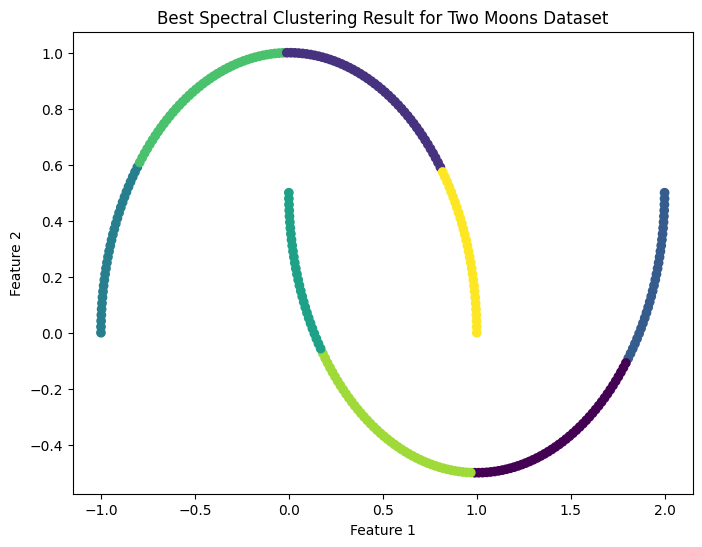

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_moons

# Generate the two moons dataset
X, y = make_moons(n_samples=300, noise=0, random_state=42)

# Define custom scoring for GridSearchCV
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) < 2:  # Silhouette needs at least 2 clusters
        return -1
    return silhouette_score(X, labels)

# Model and parameter grid
param_grid = {
    'n_clusters': [i for i in range(1, int(len(X) ** 0.5))],
    'n_neighbors': [i for i in range(10, int(len(X) ** 0.5), 10)],
    'affinity': ['nearest_neighbors']
}

# GridSearchCV setup
model = SpectralClustering(random_state=42, assign_labels='kmeans')
grid_search = GridSearchCV(model, param_grid, scoring=silhouette_scorer, cv=3)
grid_search.fit(X)

# Best parameters and score
print("Best Params:", grid_search.best_params_)
print("Best Silhouette Score:", grid_search.best_score_)

# Plot the best clustering result
best_model = grid_search.best_estimator_
best_labels = best_model.fit_predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=best_labels, cmap='viridis')
plt.title('Best Spectral Clustering Result for Two Moons Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


## Data Loading

playing with tinystories dataset

In [17]:
# download the tinystories dataset
from datasets import load_dataset

dataset = load_dataset("roneneldan/TinyStories", split="train")

/Users/isabella_zhu/nanoGPT/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
texts = [example["text"] for example in dataset]
k = 10
training = ["<|endofstory|>".join(texts[i:i+k]) for i in range(0, len(texts) - k, k)]

In [19]:
training[0]

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.<endofstory>Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had many leaves t

In [6]:
import pickle

file = "out-tinystories-cluster/839.pkl"
with open(file, 'rb') as file:
    df = pickle.load(file)
print(df.head())

AttributeError: 'numpy.ufunc' object has no attribute '__module__'

In [7]:
import joblib

df = joblib.load("out-tinystories-cluster/839.pkl")
print(df.head())

AttributeError: 'numpy.ufunc' object has no attribute '__module__'

In [10]:
import pandas as pd
file = "839.pkl"
df = pd.read_pickle(file)

RuntimeError: empty_like method already has a different docstring

## Clustering on Random Points

In [14]:
import random

# randomly generated data in the shape of GPT embeddings
X = []
for i in range(256):
    v = []
    for j in range(384):
        v.append(random.random() * 2 - 1)
    X.append(v)

In [8]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import GridSearchCV

In [12]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) < 2:  # Silhouette needs at least 2 clusters
        return -1
    return silhouette_score(X, labels)

def cluster(X):
    # Model and parameter grid
    param_grid = {
        'n_clusters': [i for i in range(1, int(len(X) ** 0.5))],
        'n_neighbors': [i for i in range(5, 30, 5)],
        'affinity': ['nearest_neighbors']
    }

    # GridSearchCV setup
    model = SpectralClustering(random_state=42, assign_labels='kmeans')
    grid_search = GridSearchCV(model, param_grid, scoring=silhouette_scorer, cv=3)
    grid_search.fit(X)

    # Best parameters and score
    print("Best Params:", grid_search.best_params_)
    print("Best Silhouette Score:", grid_search.best_score_)

    # Plot the best clustering result
    best_model = grid_search.best_estimator_
    best_labels = best_model.fit_predict(X)

    return best_labels

In [15]:
cluster(X)

Best Params: {'affinity': 'nearest_neighbors', 'n_clusters': 15, 'n_neighbors': 15}
Best Silhouette Score: 0.007366127656333114


array([ 1, 11,  8,  9, 11,  6,  8, 11,  1,  2,  4,  3,  9,  1,  0,  9,  2,
        6,  4,  6,  5,  6,  9,  3, 10,  9,  3, 14,  1, 11,  1, 13, 11,  8,
        9,  5,  4,  9,  8,  6, 12,  6, 14,  8,  3,  4, 11,  3, 11,  3,  0,
        1,  3,  3,  0, 14,  3,  2,  8,  1,  6, 11,  8,  9, 11,  0, 10,  1,
        8,  9, 14, 11,  3, 13,  0,  4,  4,  6,  9, 11,  6, 11,  2, 11,  3,
       13,  1,  1,  4, 13,  4, 11, 12,  4, 10, 13,  7,  1,  3,  0,  4, 12,
        1,  6,  4,  1,  9,  3,  0, 11,  7,  0, 10, 14,  9,  5,  0,  1,  1,
        4, 12,  2,  0,  1,  8,  4,  2, 13,  8,  4,  8, 11,  7, 13,  0,  0,
        2,  8,  3,  3, 12,  2,  3, 12,  0,  3,  1, 10, 13, 11,  7,  0,  0,
        2, 13,  8,  3,  1,  6,  9,  4,  6,  4,  0, 12,  0,  6,  4, 11,  6,
        3,  3,  4,  4,  0,  9,  3, 11, 11,  7,  3,  3,  2,  4,  1,  7,  1,
       10,  4, 13,  6,  0, 14,  9,  2,  1,  9,  5,  4,  1,  5,  6,  9, 13,
       12,  6, 14,  7, 11, 12,  0, 12, 13,  6, 10, 11,  3,  1, 14,  8,  2,
        7,  0, 12,  4,  9